In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('data/transfers_since_2013.parquet')

In [3]:
# new column: Property Class as integer
df['PropClass'] = pd.to_numeric(df['Class_desc'].str[:3], errors='coerce')

In [4]:
# filter to SFH only
# 43081 out of 55053 transfers were single-family homes
df = df.loc[df['PropClass'].isin([101,110,115,120,130,150])]

We have a couple of markers for identifying flips vs. new housing:

If YrBuilt is <2 years before Transfer_date, it's new housing

If YrBuilt is NaN, it's probably a vacant lot

In [53]:
df

,Parcel_ID,Card,Class_desc,NBHDno,NBHDname,district_number,Prop_stree,Transfer_date,Consideration,Transfer_comment,...,Deed_page,Grantor,Grantee,Story,YearBlt,FinArea,TransferComment,YrBuilt,FinSize,PropClass
0,C0010124012,nan,101 Single Family Vacant (R1-R6),140.0,Traylor Estate/Huguenot Farms,4.0,8780 RIVERSIDE DR,2012-07-24,200000,Multi-Parcel Sale,...,14350,WILEY JOANN T,PRINCE J STEPHEN & ELIZABETH N,NaN,NaN,NaN,nan,NaN,NaN,101.0
1,C0010126020,R01,110 One Story,140.0,Traylor Estate/Huguenot Farms,4.0,8781 RIVERSIDE DR,2012-07-24,700000,Multi-Parcel Sale,...,14351,WILEY JOANN T,PRINCE J STEPHEN & ELIZABETH R,1.0,1930.0,2656.0,nan,NaN,NaN,110.0
2,C0010126026,R01,110 One Story,148.0,SouthHampton/Oxford,4.0,8646 RIVERCREST ROAD,2012-10-19,0,Related Parties,...,20843,CORKRAN LAVERN H,CORKRAN LAVERN H & DOUGLAS E,1.0,1956.0,2808.0,nan,NaN,NaN,110.0
3,C0010126028,R01,110 One Story,140.0,Traylor Estate/Huguenot Farms,4.0,8724 RIVERCREST ROAD,2012-07-24,200000,Multi-Parcel Sale,...,14350,WILEY JOANN T,PRINCE J STEPHEN & ELIZABETH R,1.0,1960.0,560.0,nan,NaN,NaN,110.0
4,C0010210022,R01,"115 One Story+ (1.25, 1.5, 1.75)",140.0,Traylor Estate/Huguenot Farms,4.0,8819 RIVERSIDE DR,2012-09-26,365333,Related Parties,...,19063,HORWITZ LOUIS H,HORWITZ TRACEY,1.5,1948.0,3685.0,nan,NaN,NaN,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55043,W0220162004,R01,120 Two Story,132.0,Ampthill/Hmptn Hlls/Hillcrest,106.0,7 River Road,2022-02-18,950000,nan,...,4215,BILLETT BETH,EBERHARDT WILLIAM,2.0,NaN,NaN,nan,1925.0,2934.0,120.0
55044,W0220162005,R01,120 Two Story,132.0,Ampthill/Hmptn Hlls/Hillcrest,106.0,9 River Road,2022-01-20,1725000,nan,...,1658,GIBSON PEARSON G,GATES RICHARD WILLIAMS AND,2.0,NaN,NaN,Asmnt/Sale Desc Doesn't Match,1937.0,3336.0,120.0
55050,W0220191007,R01,120 Two Story,136.0,Windsor Farms/Rothesay,106.0,206 Gun Club Road,2022-01-28,940000,nan,...,2425,KENNY ANNE W TRUSTEE,BROCK LESTER C III AND,2.0,NaN,NaN,Asmnt/Sale Desc Doesn't Match,1967.0,3341.0,120.0
55051,W0220222011,R01,120 Two Story,136.0,Windsor Farms/Rothesay,106.0,211 Berkshire Road,2022-01-04,1300000,nan,...,43,GLOSSOP SIMON G AND ELLA CARSON,ALAS KEVIN AND KELSEY B,1.0,NaN,NaN,nan,1951.0,3410.0,120.0


In [97]:
df['sale'] = df['Deed_book'] + '.' + df['Deed_page']
#pre-work: group by parcel_id (and sale) and only keep columns we need
preflips = df.groupby(['Parcel_ID','Grantor','Grantee','sale']).agg({'NBHDno':'min','district_number':'min',
                                      'Transfer_date':'min',
                                      'Consideration':'min',
                                      'TransferComment': ';'.join,
                                      'YrBuilt':'min',
                                      'FinSize':'sum'})

In [98]:
preflips.reset_index(inplace=True)

In [99]:
# identify parcels resold 
# I think a self-join makes the most sense
flips = preflips.merge\
    (preflips,left_on = ['Parcel_ID', 'Grantee'], right_on = ['Parcel_ID', 'Grantor'], how='inner')
flips.shape

(9706, 21)

In [100]:
# Add timedelta column for how long the property was held for
flips['hold_time'] = flips['Transfer_date_y'] - flips['Transfer_date_x']

<AxesSubplot:>

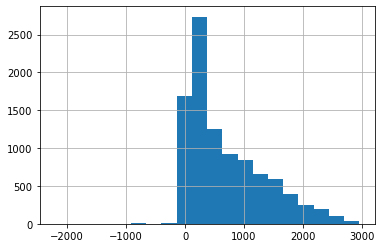

In [101]:
flips['hold_time'].dt.days.hist(bins=20)

In [102]:
# filter out:
# hold times < 0 - these are probably cycles (30 rows)
flips = flips.loc[flips['hold_time'].dt.days >= 0]
# hold times > 2 years - probably somebody just lived there and then moved (3719 rows)
flips = flips.loc[flips['hold_time'] < pd.Timedelta(365*2, "d")]
flips.shape

(6026, 22)

In [103]:
# add a column for price difference
flips['price_diff'] = flips['Consideration_y'] - flips['Consideration_x']

In [104]:
flips = flips.loc[flips['price_diff']>0] # exclude 1361 rows
# warning: some of the large negative price differences are due to the first sale being "multiple parcels"
# for our purposes, I don't think that's immediately relevant, since most flippers seem to buy houses individually.
flips.shape

(4677, 23)

In [105]:
# drop invalid sales
# how many are 'invalid sales'? about a quarter of the remaining rows - 1151 / 4742
# many of them are 
#flips.loc[flips['TransferComment_y'] != 'nan']
# exclude certain invalid sales - keep the rest for now
flips = flips.loc[~flips['TransferComment_y'].isin(['Foreclosure Related/Short Sale','Sale Includes Multiple Parcels','Special Financing/Terms, etc.'])]
flips.shape

(4407, 23)

In [110]:
# drop flips where the first sale was 0 sq ft - probably a vacant lot
flips = flips.loc[flips['FinSize_x']>0]
flips.shape

(4076, 24)

In [106]:
# let's add the difference in sq.footage - a good sign of a serious renovation
flips['size_diff'] = flips['FinSize_y'] - flips['FinSize_x']

In [107]:
#flips.shape
#flips.sort_values(['price_diff']).tail(20)

#
flips.loc[~flips['size_diff'].isna()].sort_values(['price_diff']).tail(10)

,Parcel_ID,Grantor_x,Grantee_x,sale_x,NBHDno_x,district_number_x,Transfer_date_x,Consideration_x,TransferComment_x,YrBuilt_x,...,NBHDno_y,district_number_y,Transfer_date_y,Consideration_y,TransferComment_y,YrBuilt_y,FinSize_y,hold_time,price_diff,size_diff
9079,W0190182013,PURSLEY TONIA JOSETTE TRUST,XTREME HOMES LLC,ID2019.14053,110.0,111.0,2019-07-15,251500,Asmnt/Sale Desc Doesn't Match,1942.0,...,110.0,111.0,2020-07-16,909000,nan,2020.0,3986.0,367 days,657500,2041.0
9594,W0210255028,LESSIN JEFFREY A,RIDGE HOMES LLC,ID2018.19657,102.0,101.0,2018-09-21,180000,Asmnt/Sale Desc Doesn't Match,2019.0,...,102.0,101.0,2019-05-29,839000,nan,2019.0,3552.0,250 days,659000,672.0
9598,W0210261013,BEAVER CREEK COMPANY LLC,LANCASTER CUSTOM BUILDERS INC,ID2016.243,102.0,102.0,2016-01-06,220000,Sale Outside Market Range;Sale Outside Market ...,2016.0,...,102.0,102.0,2016-10-07,899000,nan;nan,2016.0,3337.0,275 days,679000,0.0
9408,W0200152020,BROOKS CARTER P & MONICA S,BOTENS GEORGE T,ID2019.3868,124.0,104.0,2019-03-01,49961,"Foreclosure, Forced Sale etc.",1928.0,...,124.0,104.0,2019-06-20,760000,nan,1928.0,2988.0,111 days,710039,0.0
9673,W0220161011,WILLIAMSON GEORGE T AND,TWIN BLESSINGS VIII LLC,ID2017.15210.0,132.0,106.0,2017-07-24,1000000,nan,1934.0,...,132.0,106.0,2018-12-12,1725000,nan,1934.0,5189.0,506 days,725000,388.0
8052,W0000666042,COFFEY ANNE R TRUSTEE &,CAPITAL CITY PROPERTIES LLC,ID2020.27773,216.0,204.0,2020-11-20,700000,nan,1910.0,...,216.0,204.0,2022-01-21,1475000,nan,1910.0,4110.0,427 days,775000,0.0
9597,W0210261012,CLINARD R N AND MARGARET H,LANCASTER CUSTOM BUILDER,ID2016.5492,102.0,102.0,2016-03-28,318550,"Special Financing/Terms, etc.",2017.0,...,102.0,102.0,2017-07-06,1095000,Asmnt/Sale Desc Doesn't Match,2017.0,3182.0,465 days,776450,-25.0
9166,W0190236023,EARLE AKEMI,SIWEL RENOVATIONS LLC,ID2020.7275,114.0,105.0,2020-04-07,367500,nan,1941.0,...,114.0,105.0,2020-12-07,1145000,nan,1941.0,3347.0,244 days,777500,0.0
9626,W0210348012,TROUT WILLIAM E III & STRAN L,MIDDLEBURG ASSOCIATES LLC,ID2014.14686,130.0,101.0,2014-08-22,426000,Other Invalid Sale,1920.0,...,130.0,101.0,2015-06-22,1250000,nan,1920.0,3780.0,304 days,824000,1192.0
9623,W0210347029,GREGORY ALLEN W,BYRD MICHAEL LLC,ID2016.20666,130.0,101.0,2016-10-21,406000,nan,1951.0,...,130.0,101.0,2017-09-21,1375760,nan,1951.0,5410.0,335 days,969760,3453.0


In [96]:
# Ugh. So some parcels are sub-divided into "Cards" which indicate detached "Extensions" separate from the main house.
# need to go back up and merge these records with a groupby + agg/sum
# note that some parcels (e.g. W0001166041) only have R02, no R01 extension.
# The most ridiculous are probably W0000523031 and W0000442020, 
# townhouses near Postbellum which are 1 parcel with 5-8 houses built on it
df.loc[df['Parcel_ID'].str.strip() == 'W0000442020']

,Parcel_ID,Card,Class_desc,NBHDno,NBHDname,district_number,Prop_stree,Transfer_date,Consideration,Transfer_comment,...,Grantor,Grantee,Story,YearBlt,FinArea,TransferComment,YrBuilt,FinSize,PropClass,sale
52136,W0000442020,R01,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,1540.0,120.0,ID2021.25994
52137,W0000442020,R02,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,990.0,120.0,ID2021.25994
52138,W0000442020,R03,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,1540.0,120.0,ID2021.25994
52139,W0000442020,R04,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,960.0,120.0,ID2021.25994
52140,W0000442020,R05,120 Two Story,224.0,Fan South to RMA,504.0,15 1/2 Randolph St,2021-09-09,1326200,nan,...,ECK ENTERPRISES INC,METRO PROPERTIES INC,2.0,NaN,NaN,Sale Includes Multiple Parcels,1900.0,990.0,120.0,ID2021.25994


In [121]:
# Hmm. How do the margins on resale vary over time?
flips['year'] = flips['Transfer_date_y'].dt.year
flip_yrs = flips.groupby('year').agg({'price_diff':['mean','median','std']}).reset_index()
flip_yrs.columns = ['year','mean','median','std']

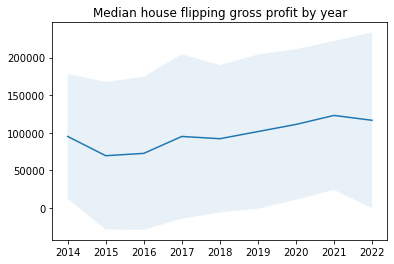

In [131]:
import matplotlib.pyplot as plt
import plotly_express as px

plt.plot('year', 'median', data=flip_yrs)
plt.fill_between(flip_yrs['year'],flip_yrs['median']-flip_yrs['std'],flip_yrs['median']+flip_yrs['std'],alpha=.1)

plt.title('Median house flipping gross profit by year')
plt.show()

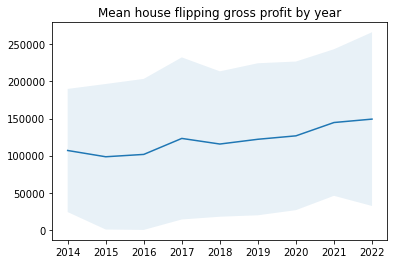

In [132]:
import matplotlib.pyplot as plt
import plotly_express as px

plt.plot('year', 'mean', data=flip_yrs)
plt.fill_between(flip_yrs['year'],flip_yrs['mean']-flip_yrs['std'],flip_yrs['mean']+flip_yrs['std'],alpha=.1)

plt.title('Mean house flipping gross profit by year')
plt.show()